## Citation  
#### Lewis, P., Perez, E., Piktus, A., Petroni, F., Karpukhin, V., Goyal, N., Küttler, H., Lewis, M., Yih, W.-T., Rocktäschel, T., Riedel, S., & Kiela, D. (2020). Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks. arXiv:2005.11401. https://doi.org/10.48550/arXiv.2005.11401

#### This notebook is a personal explanation and walkthrough of the paper *Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*. All credit for the original research goes to the authors listed above.

**Image Attribution**

#### Unless otherwise noted, all figures in this notebook are either original or sourced from Lewis et al., 2020 – *Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*.


# Overview of Retrieval-Augmented Generation (RAG)

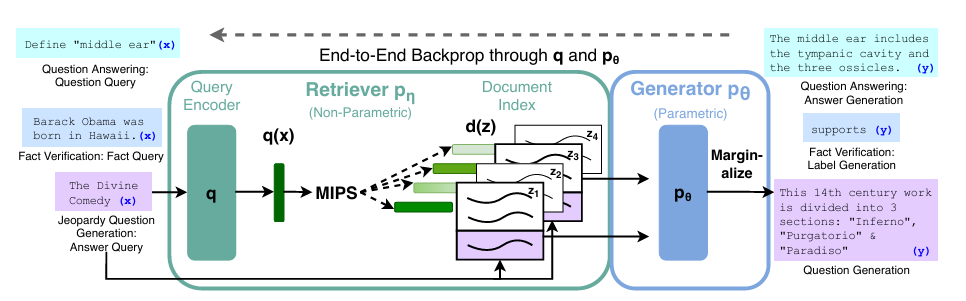

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Images/Overview.png')

#### RAG consists of two parts: Retriever + Generator. When the user enters a question/query (x), the question gets passed to the Retriever component. Then the retrieved documents along with the query goes to the Generator component. The output of the Retriever component provides additional context to the Generator which will provide correct answers.

#### Retriever used is Dense Passage Retriever (DPR). It fetches top-k relevant documents (z) from the vector database.
#### Genrator used is BART. It generates the answer (y) from the query (x) and the documents fetched by the DPR (z).

# Retriever (DPR)

#### Retriver is non parametric, meaning it doesn't store any information in the memory (parameters). Retriever used in the RAG is DPR.
#### Let's check the formula given: 

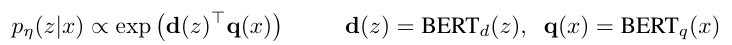

In [2]:
%matplotlib inline
from IPython.display import Image
Image('Images/DPR.png')

#### where,
####   d(z) is the dense representation of the document, 
####   q(x) is the dense representation of the query

####  p_eta(z|x) is proportional to exponential(d(z)_transpose * q(x)) because product of document representation and query representation tells us how close the query and document are related. The higher the product (score), the closer are their meanings. The exponential ensures that all the scores are positive. To turn these scores into a probability distribution, softmax normalization is used. For more information about the DPR, check out the Dense Passage Retriever Explanation in this github repository.

# Generator (BART)

#### BART-Large is used. BART-large is a seq2seq Transformer with 400M parameters. Since, it stores the information in memory (parameters), this step is called parametric.
#### BART concatenates the query (x) with the retrieved content (z). This is required to generate the accurate answers, the model will need accurate context. Retriever component fetches the required documents. For more information about BART, check out the Dense Passage Retriver Explanation in this github repository.

# 2 Types of RAG Model:

#### 1) RAG Sequence Model
#### 2) RAG Token Model

# 1) RAG Sequence Model

#### The Retriever fetches the top-k most relevant documents. For each document, the Generator produces a full answer and calculates the probability based on that document alone. These probabilities are then weighted by the relevance of each document and summed (marginalized) to decide the final answer.

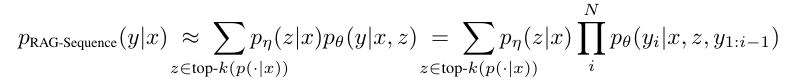

In [3]:
%matplotlib inline
from IPython.display import Image
Image('Images/RAG_Sequence_Model.png')

#### In the above formula, the probablity of finding the document given query, p_eta(z|x), tells us how much a given document from the top-k documents is relevant to the query. Let's call this 'how_relevan_is_this_document'.
#### p_theta(y | x, z) is the probablity of finding the answer from the document. Let's call this 'finding_answer_from_the_selected_document'.

#### The Probability of the answer given the query using the RAG Sequence is approximately equal to product of how_relevant_is_this_document and finding_answer_from_the_selected_document

# 2) RAG Token Model

#### The Retriever fetches the top-k relevant documents. Instead of generating the whole answer from each document separately, the Generator produces the answer token by token. for generating  each token, it looks at all retrieved documents and combines their information to choose the next token. This allows the model to look for tokens from different documents at different points in the answer.

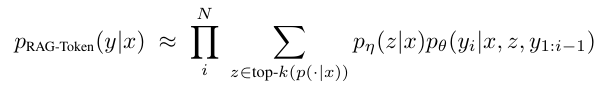

In [5]:
%matplotlib inline
from IPython.display import Image
Image('Images/RAG_Token_Model.png')

#### In the above formula, the probablity of finding the document given query, p_eta(z|x), tells us how much a given document from the top-k documents is relevant to the query. Let's call this 'how_relevant_document_is_this_document'.
#### p_theta(y | x, zm y_(1:i-1)) is the probablity of finding the answer from the document. Let's call this 'finding_token_from_the_each_document'.

#### The Probability of the answer given the query using the RAG Sequence is approximately equal to product of how_relevant_document_is_this_document and finding_token_from_the_each_document

# Decoding
#### Decoding is the process of turning the model’s predicted probabilities into an actual output sequence (answer).

## Beam Search
#### Beam Search keeps track of top-k likely partial sequences (called beams) for each token. For the next token to be predicted, it expands each of those sequences with all possible next tokens, scores them and keeps the best-k partial sequences again. This goes on till the answer or the sequence is complete.

# 1) RAG Sequence Model

#### a) Thorough Decoding: After running beam search for each retrieved document, if an answer candidate didn’t appear in a document’s beam, we still run an extra forward pass with that document to calculate its probability. This makes it more accurate because we are calaculating all the possibilities but it also makes it slower.

#### Fast Decoding: We skip those extra forward passes where the token does not appear in the document and assume the probability is zero. This makes it faster because we avoid a lot of extra computation but it is an approximate answer.

# 2) RAG Token Model

#### Beam Search mixes information of all the top-k documents because the answer is generated token by token. Hence, it is faster and cheaper than RAG Sequence Model

# Experiments

#### Wikipedia (Dec 2018 dump) is used for the experiements. It consists of 21M chunks of 100 words each.

## 1) Open-Domain Question Answering (QA)
#### Goal: Answer factual questions without being restricted to single dataset. 
#### Questions and answers as input-output text pairs (x, y)
#### RAG is compared against 2 methods:
#### a) Extractive QA: It finds the exact answer span from retrieved documents. (no generator)
#### b) Closed-Book QA: Relies only on the model's internal memeory (no retriever)

#### RAG can combine Retrieval + Generation so it can both find and phease the answer.
#### Exact Match (EM) metric is used. It tells the percentage of answers exactly matching the correct answer.

#### Result: 

## 2) Abstractive Question Answering
#### Goal: Test if RAG can generate natural, free-form answers from knowledge.
#### MS MARCO NLG dataset is used.
#### RAG was only given the question so it had to rely on retrieved Wikipwedia documents + parametric knowledge.
#### Challenge was some questions could not be answered if it is not present in the Wikipedia. It shows that RAG can handle situations where retrieval is incomplete.

## 3) Jeopardy Question Generation
#### Goal: Flip the QA task. That is, given an answer, generate a question.
#### For example: "The World Cup" is the answer to the question "In “In 1986 Mexico scored as the first country to host this international sports competition twice"
#### Dataset used is Search QA. Evaluation metric used is Q-BLEU-1 (Special BLEU score varient that rewards correct entity answers).
#### Human evaluation is done for Factuality (is the generated question factually correct?) and Specificity (is the question generated specifically tied to the given answer?).

## 4) Fact Verification (FEVER)
#### Goal: Given a claim, classify if it is supported or refuted by Wikipedia, or whether there is not enough information to decide.
#### RAG did not get the supervision about which exact evidence to use.
#### Metric used is Label Accuracy.

# Conclusion
#### RAG (Retrieval Augmented Generation) combines parametric language model and non-parametric retrivel from large corpus. This allows it to generate accurate, context-aware responses.